In [ ]:
import sys
sys.path.append('C:\\Users\\Lee Geonju\\Desktop\\drone\\PythonClient')
sys.path.append('C:\\Users\\Lee Geonju\\Desktop\\drone\\PythonClient\\reinforcement_learning')
sys.path.append('C:\\Users\\Lee Geonju\\Desktop\\drone\\PythonClient\\reinforcement_learning\\airgym')
import time
import wandb
import airsim
import numpy as np
import math

import wandb
import airsim
import numpy as np
import torch
from airgym.envs.airsim_env import AirSimEnv
from gym import spaces

In [ ]:
class AirSimDroneEnv(AirSimEnv):
    def __init__(self, ip_address, step_length, image_shape):
        super().__init__(image_shape)
        self.step_length = step_length
        self.image_shape = image_shape

        self.state = {
            "position": np.zeros(3),
            "collision": False,
            "prev_position": np.zeros(3),
        }

        self.drone = airsim.MultirotorClient(ip=ip_address)
        self.action_space = spaces.Discrete(7)
        self._setup_flight()

        self.image_request = airsim.ImageRequest(
            "0", airsim.ImageType.DepthVis, True, False
        )

    def __del__(self):
        self.drone.reset()

    def _setup_flight(self):
        self.drone.reset()
        self.drone.enableApiControl(True)
        self.drone.armDisarm(True)
        
        # Set home position and velocity
        self.drone.takeoffAsync().join()
        #self.drone.moveToPositionAsync(212, -320, -19.0225, 10).join()
        #self.drone.moveByVelocityAsync(1, -0.67, -0.8, 5).join()

    def transform_obs(self, responses):
        img1d = np.array(responses[0].image_data_float, dtype=np.float)
        img1d = 255*img1d.clip(0, 1)
        img2d = np.reshape(img1d, (responses[0].height, responses[0].width))

        from PIL import Image

        image = Image.fromarray(img2d)
        im_final = np.array(image.resize((84, 84)).convert("L"))

        return im_final.reshape([84, 84, 1])

    def _get_obs(self):
        responses = self.drone.simGetImages([self.image_request])
        image = self.transform_obs(responses)
        self.drone_state = self.drone.getMultirotorState()

        self.state["prev_position"] = self.state["position"]
        self.state["position"] = self.drone_state.kinematics_estimated.position
        self.state["velocity"] = self.drone_state.kinematics_estimated.linear_velocity

        collision = self.drone.simGetCollisionInfo().has_collided
        self.state["collision"] = collision

        return image

    def _do_action(self, action):
        if action == 0:  # turn left
            self.drone.rotateByYawRateAsync(-8, 1)#.join()
        elif action == 1:  # turn right
            self.drone.rotateByYawRateAsync(8, 1)#.join()
        elif action == 2:  # forward
            self.drone.moveByVelocityBodyFrameAsync(5, 0, 0, 100)
            #for vel in np.linspace(5, 0, 3):
            #    future = self.drone.moveByVelocityBodyFrameAsync(vel, 0, 0, 2)
            #future.join()
        time.sleep(2)

    def _compute_reward(self):
        thresh_dist = 7
        beta = 1

        z = -10
        pts = [
            np.array([-0.55265, -31.9786, -19.0225]),
            np.array([48.59735, -63.3286, -60.07256]),
            np.array([193.5974, -55.0786, -46.32256]),
            np.array([369.2474, 35.32137, -62.5725]),
            np.array([541.3474, 143.6714, -32.07256]),
        ]

        quad_pt = np.array(
            list(
                (
                    self.state["position"].x_val,
                    self.state["position"].y_val,
                    self.state["position"].z_val,
                )
            )
        )

        if self.state["collision"]:
            reward = -100
        else:
            dist = 10000000
            for i in range(0, len(pts) - 1):
                dist = min(
                    dist,
                    np.linalg.norm(np.cross((quad_pt - pts[i]), (quad_pt - pts[i + 1])))
                    / np.linalg.norm(pts[i] - pts[i + 1]),
                )

            if dist > thresh_dist:
                reward = -10
            else:
                reward_dist = math.exp(-beta * dist) - 0.5
                reward_speed = (
                    np.linalg.norm(
                        [
                            self.state["velocity"].x_val,
                            self.state["velocity"].y_val,
                            self.state["velocity"].z_val,
                        ]
                    )
                    - 0.5
                )
                reward = reward_dist + reward_speed

        done = 0
        if reward <= -10:
            done = 1

        return reward, done

    def step(self, action):
        self._do_action(action)
        obs = self._get_obs()
        reward, done = self._compute_reward()

        return obs, reward, done, self.state

    def reset(self):
        self._setup_flight()
        return self._get_obs()

In [ ]:
session_id = wandb.util.generate_id()
env = AirSimDroneEnv('127.0.0.1', 1, (84, 84))

states = [env.reset()]
actions = []
positions = []
rollout_cnt = 0

while True:
    key = airsim.wait_key(f'{len(actions)} - AWD / R / Q')
    if type(key) == bytes:
        key = key.decode()
    
    if key == 'a':
        action = 0
    elif key == 'd':
        action = 1
    elif key == 'w':
        action = 2
    elif key == 'r':
        torch.save(
            {'states': states, 'actions': actions, 'positions': positions},
            f'{session_id}_rollout{rollout_cnt}.pt'
        )
        print(f'{session_id}_rollout{rollout_cnt}.pt saved (length {len(actions)})')
        rollout_cnt += 1
        
        states = [env.reset()]
        actions = []
        continue
    elif key == 'q':
        torch.save(
            {'states': states, 'actions': actions, 'positions': positions},
            f'{session_id}_rollout{rollout_cnt}.pt'
        )
        print(f'{session_id}_rollout{rollout_cnt}.pt saved (length {len(actions)})')
        rollout_cnt += 1        
        
        states = [env.reset()]
        actions = []
        break
    else:
        print(key)
        continue
        
    next_state, _, _, info = env.step(action)
    states.append(next_state)
    actions.append(action)
    positions.append(np.array([info["position"].x_val, info["position"].y_val, info["position"].z_val]))

In [1]:
import torch
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
traj = torch.load('./p8mxp5vc_rollout0.pt')

In [3]:
len(traj['states'])

30

In [4]:
traj['states'][0].shape

(84, 84, 1)

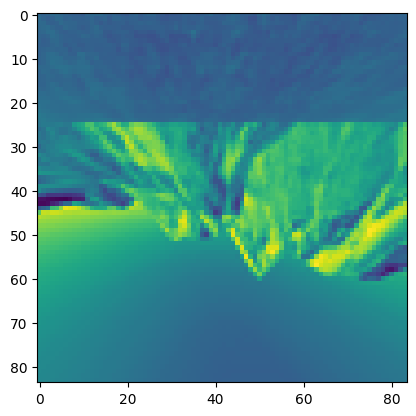

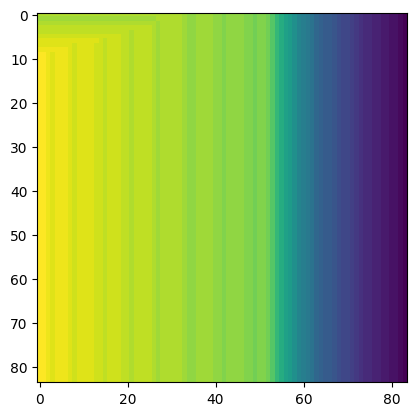

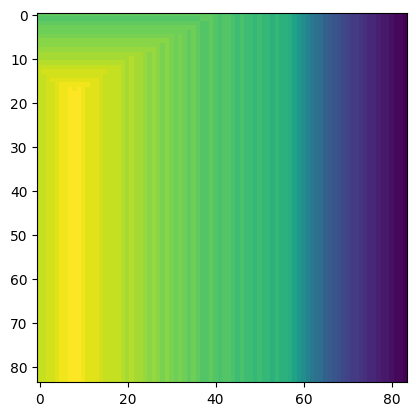

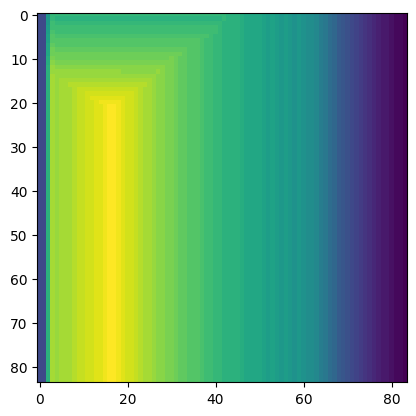

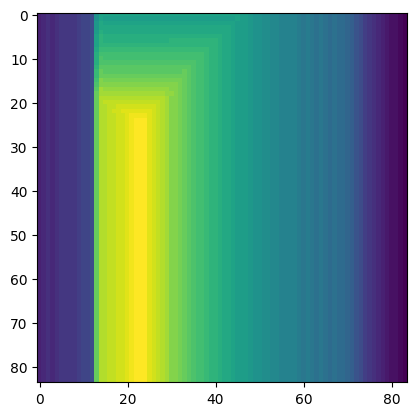

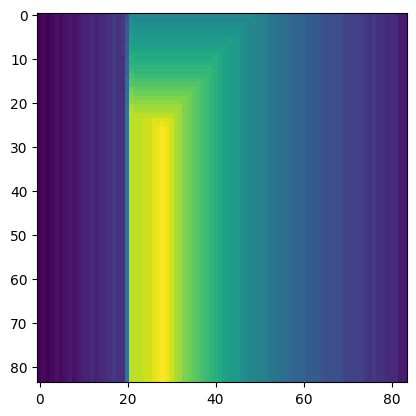

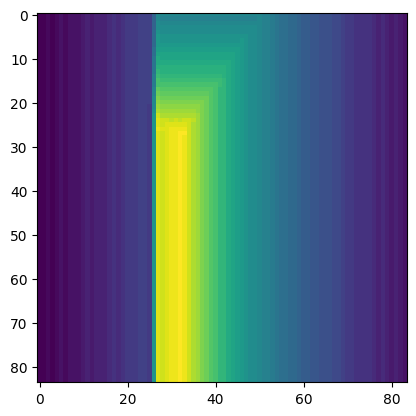

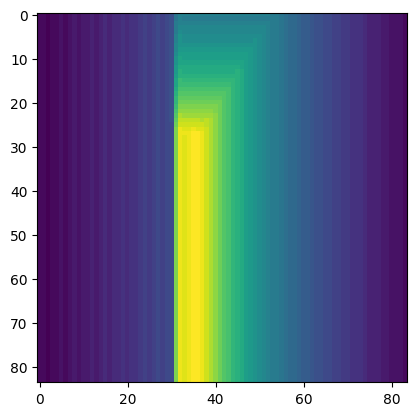

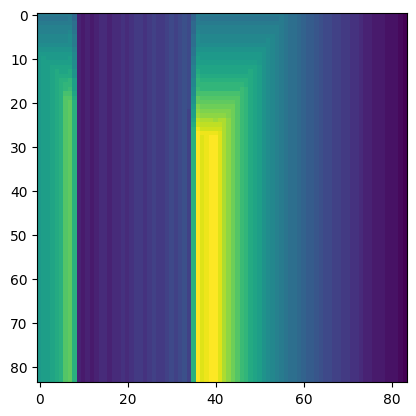

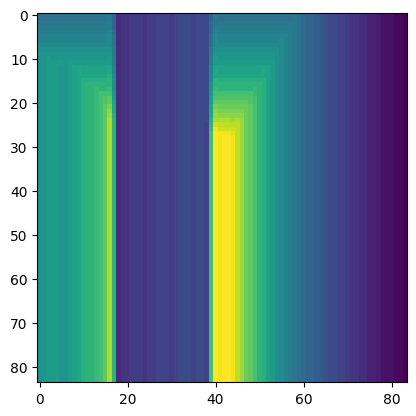

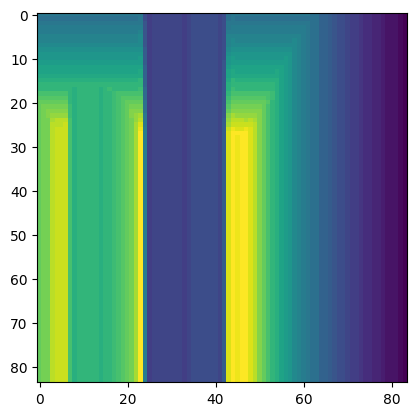

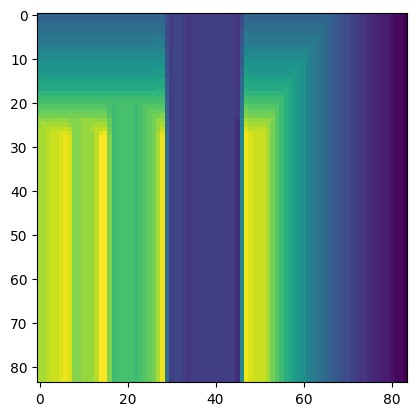

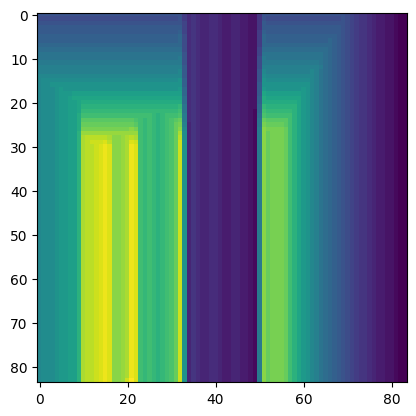

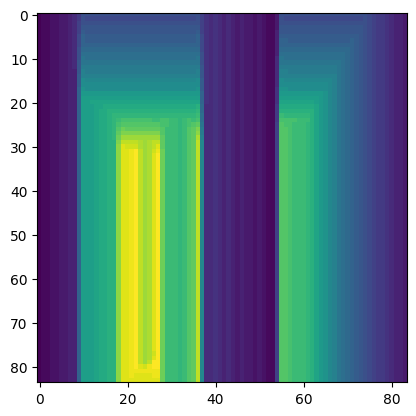

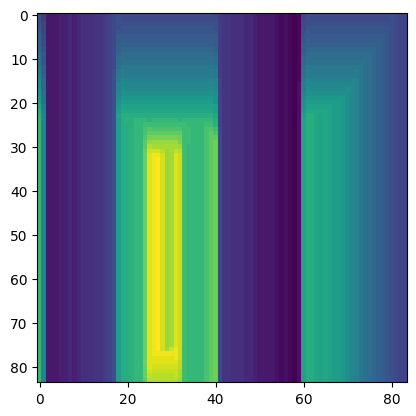

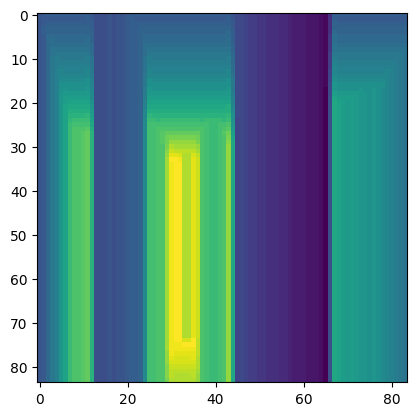

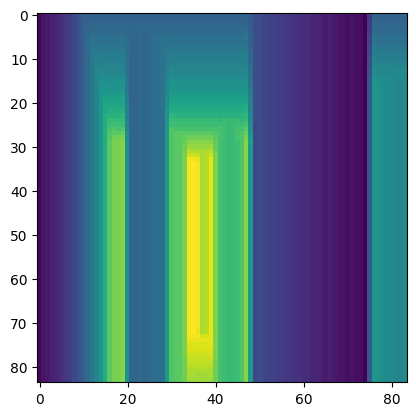

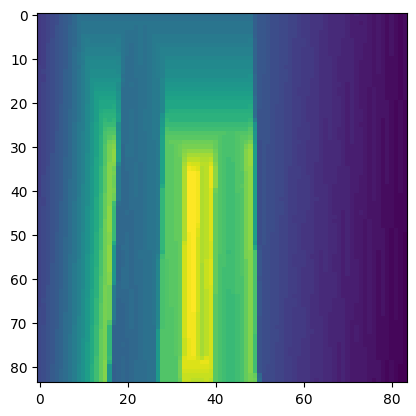

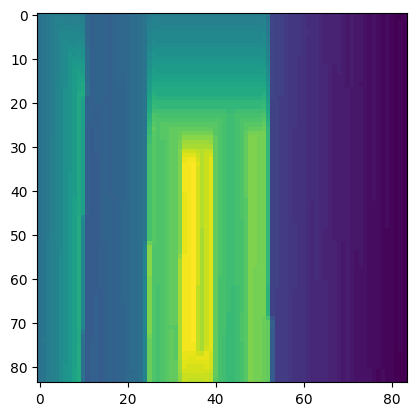

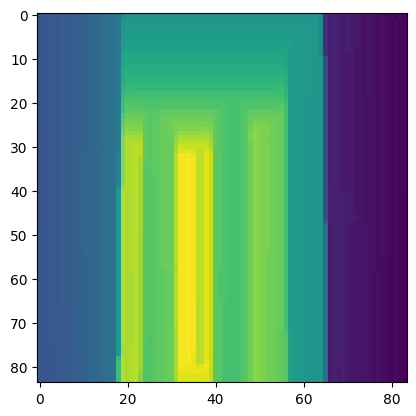

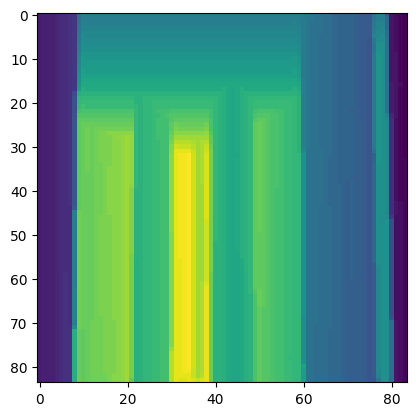

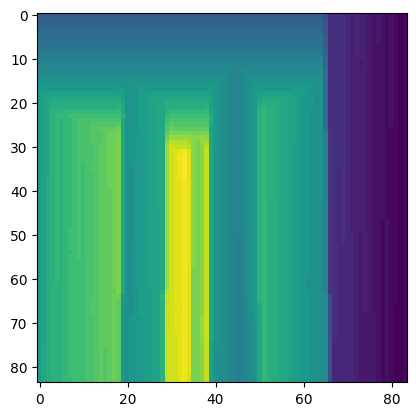

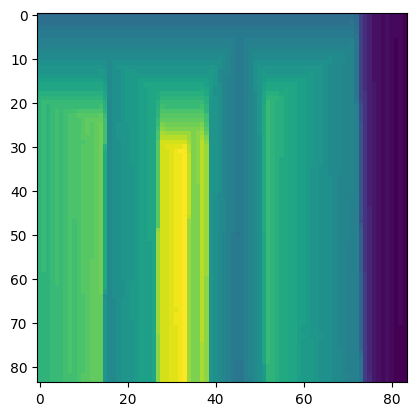

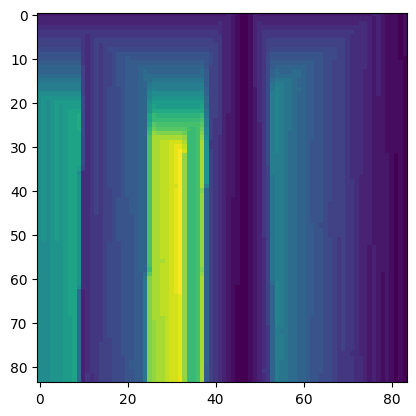

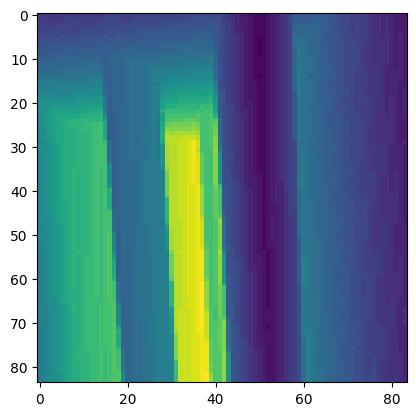

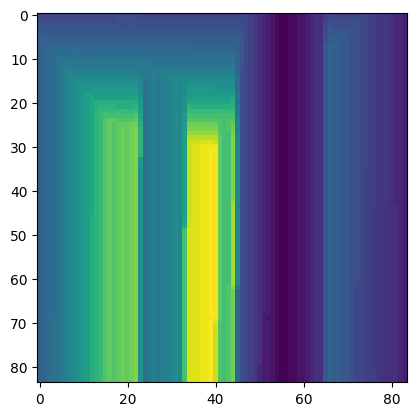

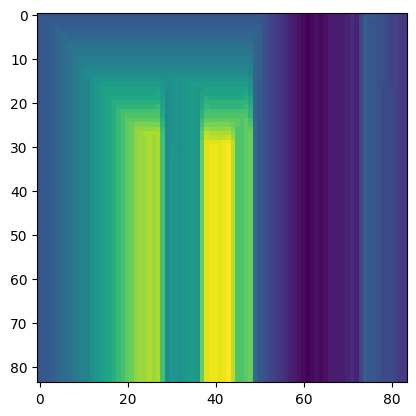

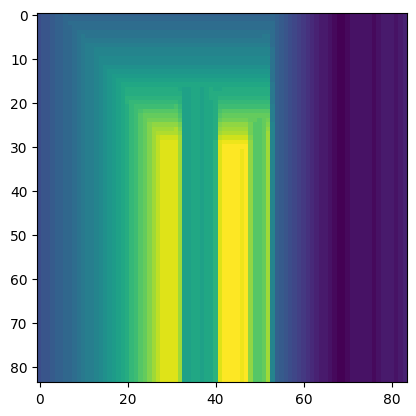

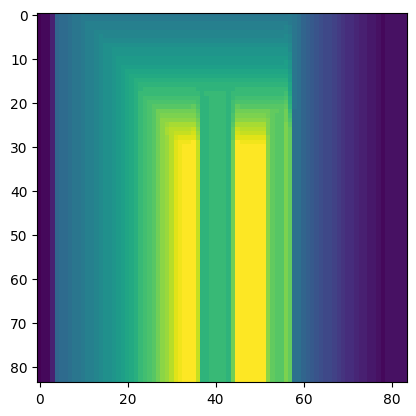

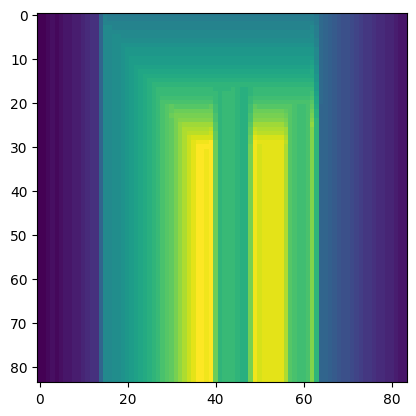

In [19]:
for i in range(30):
    plt.imshow(traj['states'][i])
    plt.show()

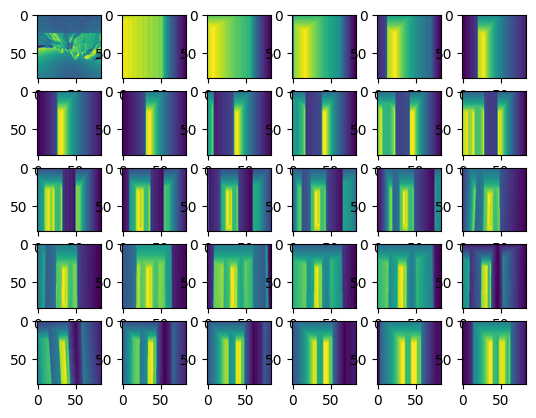

In [5]:
fig, axes = plt.subplots(5, 6)
for i in range(30):
    axes[i//6][i%6].imshow(traj['states'][i])